# Overview 

In the 10x series of notebooks, we will look at Time Series modeling in pycaret using univariate data and no exogenous variables. We will use the famous airline dataset for illustration. Our plan of action is as follows:

1. Perform EDA on the dataset to extract valuable insight about the process generating the time series. **(COMPLETED)**
2. Model the dataset based on exploratory analysis (univariable model without exogenous variables). **(COMPLETED)**
3. Use an automated approach (AutoML) to improve the performance. **(Covered in this notebook)**

In [1]:
# Only enable critical logging (Optional)
import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

In [2]:
def what_is_installed():
    from pycaret import show_versions
    show_versions()

try:
    what_is_installed()
except ModuleNotFoundError:
    !pip install pycaret
    what_is_installed()


System:
    python: 3.9.16 (main, Jan 11 2023, 16:16:36) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\Nikhil\.conda\envs\pycaret_dev_sktime_16p1\python.exe
   machine: Windows-10-10.0.19044-SP0

PyCaret required dependencies:
                 pip: 22.3.1
          setuptools: 65.6.3
             pycaret: 3.0.0rc9
             IPython: 8.10.0
          ipywidgets: 8.0.4
                tqdm: 4.64.1
               numpy: 1.23.5
              pandas: 1.5.3
              jinja2: 3.1.2
               scipy: 1.10.0
              joblib: 1.2.0
             sklearn: 1.2.1
                pyod: 1.0.8
            imblearn: 0.10.1
   category_encoders: 2.6.0
            lightgbm: 3.3.5
               numba: 0.56.4
            requests: 2.28.2
          matplotlib: 3.7.0
          scikitplot: 0.3.7
         yellowbrick: 1.5
              plotly: 5.13.0
             kaleido: 0.2.1
         statsmodels: 0.13.5
              sktime: 0.16.1
               tbats: 1.1.2
            pmdarima: 2.0.2


In [3]:
import time
import numpy as np
import pandas as pd

from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment

In [4]:
y = get_data('airline', verbose=False)

In [5]:
# We want to forecast the next 12 months of data and we will use 3 fold cross-validation to test the models.
fh = 12 # or alternately fh = np.arange(1,13)
fold = 3

In [6]:
# Global Figure Settings for notebook ----
# Depending on whether you are using jupyter notebook, jupyter lab, Google Colab, you may have to set the renderer appropriately
# NOTE: Setting to a static renderer here so that the notebook saved size is reduced.
fig_kwargs = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

# Auto Create

We have so many models to choose from. How do we know which ones perform the best. Let's see how we can do with `pycaret`.

In [7]:
exp = TSForecastingExperiment()
exp.setup(data=y, fh=fh, fold=fold, fig_kwargs=fig_kwargs, session_id=42)

,Description,Value
0,session_id,42
1,Target,Number of airline passengers
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(144, 1)"
5,Transformed data shape,"(144, 1)"
6,Transformed train set shape,"(132, 1)"
7,Transformed test set shape,"(12, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


# Compare Models

In [8]:
# Get the 3 best baseline models 
best_baseline_models = exp.compare_models(n_select=3)
best_baseline_models

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
exp_smooth,Exponential Smoothing,0.5852,0.6105,17.1926,20.1633,0.0435,0.0439,0.8918,0.2000
ets,ETS,0.5931,0.6212,17.4165,20.5103,0.0440,0.0445,0.8882,1.0900
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.6666,0.7255,19.6620,24.0121,0.0490,0.0489,0.8465,0.4000
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6813,0.7866,20.0334,25.9670,0.0491,0.0499,0.8113,0.2267
arima,ARIMA,0.6830,0.6735,20.0069,22.2199,0.0501,0.0507,0.8677,0.1267
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7004,0.7702,20.6084,25.4401,0.0509,0.0514,0.8215,3.6833
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7004,0.7703,20.6086,25.4405,0.0509,0.0514,0.8215,0.5000
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7004,0.7702,20.6084,25.4401,0.0509,0.0514,0.8215,0.2333
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.7029,0.7732,20.6816,25.5362,0.0511,0.0516,0.8201,0.5433
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.7048,0.7751,20.7366,25.6009,0.0512,0.0517,0.8192,0.2267


[ExponentialSmoothing(seasonal='mul', sp=12, trend='add'),
 AutoETS(seasonal='mul', sp=12, trend='add'),
 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [12, 11,
                                                                         10, 9,
                                                                         8, 7, 6,
                                                                         5, 4, 3,
                                                                         2, 1]},
                                                    n_jobs=1)],
                     regressor=ExtraTreesRegressor(n_jobs=-1, random_state=42),
                     sp=12, window_length=12)]

In [9]:
# We will save the metrics to be used in a later step.
compare_metrics = exp.pull()
# compare_metrics

* Note that some models like BATS and TBATS are disabled by default. 
* You can enable them by setting `turbo = False`

`best_baseline_models = exp.compare_models(n_select=3, turbo=False)`

# Tune Best Models

In [10]:
best_tuned_models = [exp.tune_model(model) for model in best_baseline_models]
best_tuned_models

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,0.3617,0.4124,10.5620,13.4978,0.0272,0.0273,0.9407
1,1957-12,0.8588,0.8856,26.2572,30.0651,0.0738,0.0703,0.7632
2,1958-12,0.3942,0.4126,11.2644,13.4112,0.0261,0.0265,0.9598
Mean,NaT,0.5382,0.5702,16.0279,18.9914,0.0424,0.0414,0.8879
SD,NaT,0.2271,0.2230,7.2389,7.8304,0.0222,0.0205,0.0885


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.6s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,0.3641,0.3969,10.6335,12.9923,0.0280,0.0281,0.9451
1,1957-12,1.0557,1.0278,32.2760,34.8945,0.0900,0.0854,0.6810
2,1958-12,0.4579,0.4697,13.0839,15.2673,0.0296,0.0302,0.9479
Mean,NaT,0.6259,0.6315,18.6645,21.0513,0.0492,0.0479,0.8580
SD,NaT,0.3063,0.2818,9.6767,9.8325,0.0288,0.0265,0.1251


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.1s finished


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,1.0549,1.2622,30.8068,41.3148,0.0755,0.0801,0.4444
1,1957-12,0.7417,0.8045,22.6769,27.3108,0.0589,0.0582,0.8046
2,1958-12,0.7252,0.8562,20.7230,27.8322,0.0448,0.0460,0.8267
Mean,NaT,0.8406,0.9743,24.7356,32.1526,0.0597,0.0614,0.6919
SD,NaT,0.1517,0.2047,4.3665,6.4822,0.0125,0.0141,0.1753


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.4s finished


[ExponentialSmoothing(seasonal='add', sp=12, trend='add', use_boxcox=True),
 AutoETS(seasonal='mul', sp=12, trend='add'),
 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [12, 11,
                                                                         10, 9,
                                                                         8, 7, 6,
                                                                         5, 4, 3,
                                                                         2, 1]},
                                                    n_jobs=1)],
                     regressor=ExtraTreesRegressor(n_jobs=-1, random_state=42),
                     sp=12, window_length=12)]

# Blend Best Models

We can achive even better results sometimes if we combine results of sevaral good models. This can be achoeved using the `blend_model` functionality. There are several options such as the `mean` blender, `'median` blender or the `voting` blender. 

The `mean` and `median` blenders takes the mean and median (respectively) of all individual model forecasts and uses that as the final forecast. The `voting` blender will combine the individual forecasts per the weights provided by the user.

Blenders can be built as such. 
* `blender = exp.blend_models(best_tuned_models, method='mean')`
* `blender = exp.blend_models(best_tuned_models, method='median')`

Let's see the voting blender in action.

In [11]:
# Get model weights to use
top_model_metrics = compare_metrics.iloc[0:3]['MAE']
display(top_model_metrics)

top_model_weights = 1 - top_model_metrics/top_model_metrics.sum()
display(top_model_weights)

exp_smooth    17.1926
ets           17.4165
et_cds_dt      19.662
Name: MAE, dtype: object

exp_smooth    0.683209
ets           0.679083
et_cds_dt     0.637708
Name: MAE, dtype: object

In [12]:
blender = exp.blend_models(best_tuned_models, method='voting', weights=top_model_weights.values.tolist())

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,1956-12,0.3703,0.4756,10.8141,15.5674,0.0264,0.0269,0.9211
1,1957-12,0.7174,0.7209,21.9328,24.4724,0.0609,0.0587,0.8431
2,1958-12,0.5437,0.5535,15.5368,17.9920,0.0353,0.0362,0.9276
Mean,NaT,0.5438,0.5833,16.0946,19.3439,0.0409,0.0406,0.8973
SD,NaT,0.1417,0.1023,4.5563,3.7591,0.0146,0.0133,0.0384


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,EnsembleForecaster,0.3310,0.3904,10.0804,13.4888,0.0219,0.0217,0.9672


           y_pred
1960-01  411.8049
1960-02  392.7194
1960-03  453.3590
1960-04  443.1362
1960-05  464.3702
1960-06  531.1468
1960-07  606.6252
1960-08  614.9484
1960-09  508.5177
1960-10  451.2852
1960-11  402.6351
1960-12  435.1540


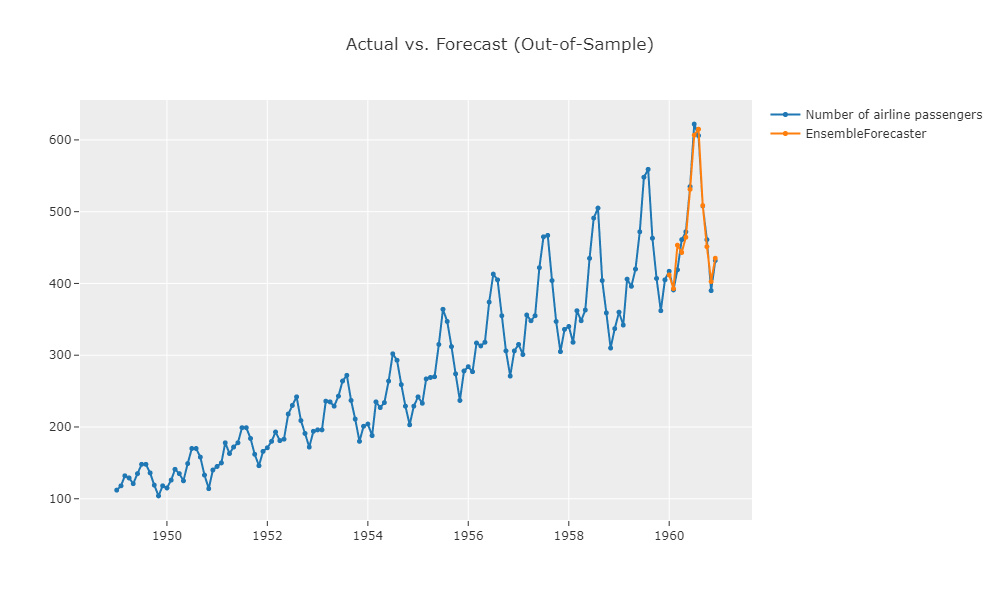

In [13]:
y_predict = exp.predict_model(blender)
print(y_predict)
exp.plot_model(estimator=blender)

# Finalize Model

           y_pred
1961-01  443.5568
1961-02  420.8623
1961-03  468.9008
1961-04  491.6614
1961-05  507.2296
1961-06  573.9883
1961-07  658.7005
1961-08  653.2689
1961-09  549.4467
1961-10  496.5341
1961-11  427.8801
1961-12  467.9969


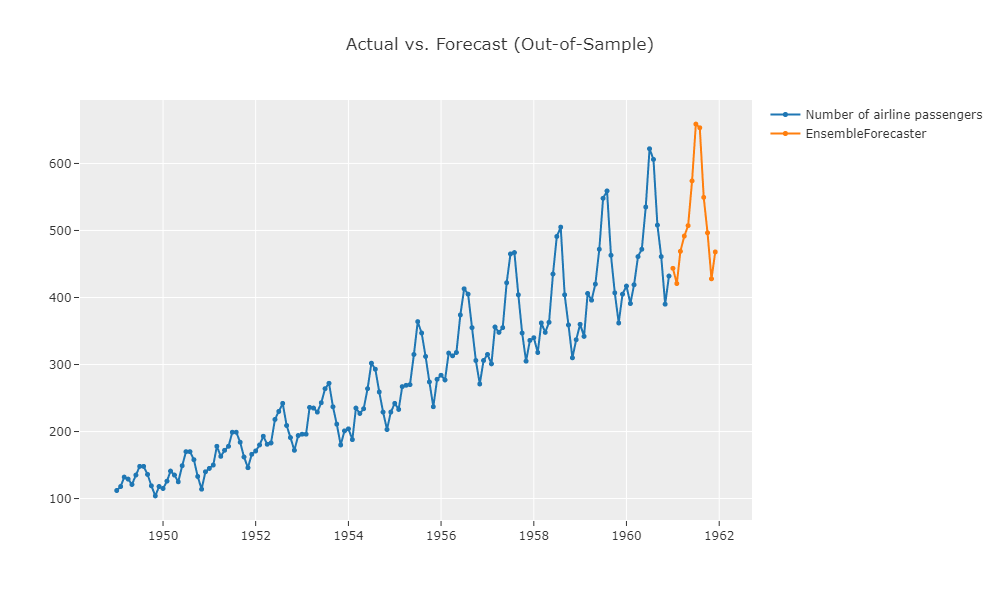

In [14]:
final_model = exp.finalize_model(blender)
print(exp.predict_model(final_model))
exp.plot_model(final_model)

# Save and Load Model

In [15]:
_ = exp.save_model(final_model, "my_blender")

Transformation Pipeline and Model Successfully Saved


In [16]:
loaded_exp = TSForecastingExperiment()
m = loaded_exp.load_model("my_blender")
# Predictions should be same as before the model was saved and loaded
loaded_exp.predict_model(m)

Transformation Pipeline and Model Successfully Loaded


,y_pred
1961-01,443.5568
1961-02,420.8623
1961-03,468.9008
1961-04,491.6614
1961-05,507.2296
1961-06,573.9883
1961-07,658.7005
1961-08,653.2689
1961-09,549.4467
1961-10,496.5341


**That's it for this notebook. Users can hopefully see how easy it was to use the automated approach to model this data and we were able to achieve reasonale results on par with (or even better than) the manual approach.**